In [3]:
!pip install torch torchvision torchaudio timm scikit-learn matplotlib opencv-python

  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.8.0-cp311-cp311-win_amd64.whl.metadata (7.2 kB)
  Using cached timm-1.0.19-py3-none-any.whl.metadata (60 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.4 MB 4.2 MB/s eta 0:00:57
   ---------------------------------------- 1.3/241.4 MB 3.4 MB/s eta 0:01

# lib Import

In [7]:
import numpy as np
print(f"NumPy version: {np.__version__}")

# scikit-learn이 로드되지 않으므로 설치된 버전 확인
import subprocess
result = subprocess.run(['pip', 'show', 'scikit-learn'], capture_output=True, text=True)
print(result.stdout)

NumPy version: 2.1.3
Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\yug67\anaconda3\envs\ML\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 



In [6]:
# 저장된 모델 테스트 및 결과 확인

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# 클래스

In [ ]:
# 1. 모델 클래스 정의 (저장된 모델과 동일한 구조)
class MemoryEfficientClassifier(nn.Module):
    def __init__(self, num_classes=4, model_size='xlarge'):
        super(MemoryEfficientClassifier, self).__init__()

        # 모델 크기별 백본 선택 (저장된 모델과 동일)
        model_configs = {
            'small': ['mobilenetv3_large_100.ra_in1k', 'efficientnet_b2.ra_in1k'],
            'medium': ['efficientnet_b3.ra2_in1k', 'efficientnet_b4.ra2_in1k'],
            'large': ['efficientnetv2_rw_m.agc_in1k', 'efficientnet_b5.ra_in1k'],
            'xlarge': [ 'efficientnetv2_m.in21k_ft_in1k', 'convnext_base.fb_in22k_ft_in1k', 'efficientnet_b6.ra_in1k' ]
        }

        # 백본 로드
        self.backbone = None
        backbone_features = None

        for model_name in model_configs[model_size]:
            try:
                self.backbone = timm.create_model(model_name, pretrained=True)
                backbone_features = self.backbone.num_features
                self.backbone.classifier = nn.Identity()
                print(f"✅ 모델 로드: {model_name}")
                break
            except:
                continue

        if self.backbone is None:
            raise RuntimeError("모델을 로드할 수 없습니다.")

        # 분류기 헤드 (저장된 모델과 동일한 구조)
        if model_size == 'small':
            hidden_size = 256
        elif model_size == 'medium':
            hidden_size = 512
        elif model_size == 'large':
            hidden_size = 768
        else:  # xlarge
            hidden_size = 1024

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(backbone_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)
        output = self.classifier(features)
        return output

# 데이터 변환

In [ ]:
# 2. 데이터 변환 (모델 훈련 시와 동일)
def get_test_transform(image_size=320):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# 검증 폴더에서 각 클래스별 샘플 선택

In [ ]:
# 3. 검증 폴더에서 각 클래스별 샘플 선택
def select_test_samples(data_path, samples_per_class=5):
    """각 클래스별로 지정된 개수만큼 샘플 선택"""

    val_path = os.path.join(data_path, 'val')
    class_samples = {}

    if not os.path.exists(val_path):
        print(f"❌ 검증 폴더를 찾을 수 없습니다: {val_path}")
        return {}

    # 클래스 폴더들 확인
    class_dirs = [d for d in os.listdir(val_path) if os.path.isdir(os.path.join(val_path, d))]
    class_dirs.sort()

    print(f"📁 발견된 클래스: {class_dirs}")

    for class_name in class_dirs:
        class_path = os.path.join(val_path, class_name)

        # 이미지 파일들 찾기
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
        image_files = []

        for ext in image_extensions:
            image_files.extend([f for f in os.listdir(class_path)
                              if f.lower().endswith(ext.lower())])

        if image_files:
            # 랜덤하게 샘플 선택
            selected_samples = random.sample(image_files,
                                           min(samples_per_class, len(image_files)))

            class_samples[class_name] = [
                os.path.join(class_path, sample) for sample in selected_samples
            ]

            print(f"   {class_name}: {len(image_files)}개 중 {len(selected_samples)}개 선택")
        else:
            print(f"   {class_name}: 이미지 파일 없음")

    return class_samples, class_dirs

# 단일 이미지 예측 (TTA적용)

In [ ]:

# 4. 단일 이미지 예측 (TTA 적용)
def predict_single_image_with_tta(model, image_path, transform, device, num_tta=5):
    """TTA를 적용한 단일 이미지 예측"""

    try:
        # 이미지 로드
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        model.eval()
        predictions = []

        with torch.no_grad():
            # 원본 이미지
            with autocast():
                outputs = model(image_tensor)
                predictions.append(F.softmax(outputs, dim=1))

            # TTA 변환들
            tta_transforms = [
                lambda x: torch.flip(x, dims=[3]),  # 수평 반전
                lambda x: torch.flip(x, dims=[2]),  # 수직 반전
                lambda x: torch.rot90(x, k=2, dims=[2, 3]),  # 180도 회전
                lambda x: x * 0.95 + 0.02,  # 밝기 조정
            ]

            for i, tta_transform in enumerate(tta_transforms[:num_tta-1]):
                try:
                    transformed = tta_transform(image_tensor.clone())
                    with autocast():
                        outputs = model(transformed)
                        predictions.append(F.softmax(outputs, dim=1))
                except:
                    continue

            # 평균 예측
            if predictions:
                avg_prediction = torch.mean(torch.stack(predictions), dim=0)
                predicted_class_idx = torch.argmax(avg_prediction, dim=1).item()
                confidence = avg_prediction[0][predicted_class_idx].item()
                class_probabilities = avg_prediction[0].cpu().numpy()

                return predicted_class_idx, confidence, class_probabilities

    except Exception as e:
        print(f"❌ 예측 오류 ({os.path.basename(image_path)}): {str(e)}")

    return None, 0.0, None

# 배치 테스트 및 결과 시각화

In [ ]:
# 5. 배치 테스트 및 결과 시각화
def test_model_comprehensive(model_path, data_path, samples_per_class=5):
    """모델 종합 테스트"""

    print("🔍 저장된 모델 종합 테스트 시작")
    print("=" * 60)

    # GPU 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 사용 디바이스: {device}")

    # 테스트 샘플 선택
    print(f"\n📁 테스트 샘플 선택 중...")
    class_samples, class_names = select_test_samples(data_path, samples_per_class)

    if not class_samples:
        print("❌ 테스트할 샘플을 찾을 수 없습니다.")
        return

    # 모델 로드
    print(f"\n🤖 모델 로딩 중...")
    try:
        model = MemoryEfficientClassifier(num_classes=len(class_names), model_size='xlarge')
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()
        print(f"✅ 모델 로드 성공: {model_path}")
    except Exception as e:
        print(f"❌ 모델 로드 실패: {str(e)}")
        return

    # 데이터 변환
    transform = get_test_transform(320)

    # 테스트 실행
    print(f"\n🎯 예측 테스트 실행 중...")
    print("=" * 80)

    all_predictions = []
    all_true_labels = []
    detailed_results = []

    for true_class_idx, (class_name, image_paths) in enumerate(class_samples.items()):
        print(f"\n📂 {class_name.upper()} 클래스 테스트:")
        print("-" * 40)

        for i, image_path in enumerate(image_paths):
            pred_class_idx, confidence, class_probs = predict_single_image_with_tta(
                model, image_path, transform, device
            )

            if pred_class_idx is not None:
                pred_class_name = class_names[pred_class_idx]
                is_correct = pred_class_idx == true_class_idx

                # 결과 저장
                all_predictions.append(pred_class_idx)
                all_true_labels.append(true_class_idx)

                detailed_results.append({
                    'image': os.path.basename(image_path),
                    'true_class': class_name,
                    'pred_class': pred_class_name,
                    'confidence': confidence,
                    'correct': is_correct,
                    'class_probs': class_probs
                })

                # 결과 출력
                status = "✅ 정답" if is_correct else "❌ 오답"
                print(f"   {i+1}. {os.path.basename(image_path)}")
                print(f"      예측: {pred_class_name} (신뢰도: {confidence:.3f}) {status}")

                # 상위 3개 예측 확률
                top3_indices = np.argsort(class_probs)[-3:][::-1]
                print(f"      상위3: ", end="")
                for idx in top3_indices:
                    print(f"{class_names[idx]}({class_probs[idx]:.2f}) ", end="")
                print()

    # 6. 결과 분석 및 시각화
    print(f"\n📊 테스트 결과 분석")
    print("=" * 60)

    if all_predictions and all_true_labels:
        # 전체 정확도
        overall_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_labels))
        print(f"🎯 전체 정확도: {overall_accuracy:.1%}")

        # 클래스별 정확도
        class_accuracies = {}
        for class_idx, class_name in enumerate(class_names):
            class_mask = np.array(all_true_labels) == class_idx
            if np.sum(class_mask) > 0:
                class_acc = np.mean(np.array(all_predictions)[class_mask] == class_idx)
                class_accuracies[class_name] = class_acc
                print(f"   {class_name}: {class_acc:.1%}")

        # 혼동 행렬
        cm = confusion_matrix(all_true_labels, all_predictions)

        plt.figure(figsize=(12, 10))

        # 혼동 행렬 시각화
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    cbar_kws={'label': 'Count'})
        plt.title(f'🎯 Confusion Matrix\nOverall Accuracy: {overall_accuracy:.1%}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # 클래스별 정확도 막대 그래프
        plt.subplot(2, 2, 2)
        classes = list(class_accuracies.keys())
        accuracies = list(class_accuracies.values())
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

        bars = plt.bar(classes, accuracies, color=colors[:len(classes)], alpha=0.8)
        plt.title('📈 Class-wise Accuracy')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.1)

        # 값 표시
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

        plt.xticks(rotation=45)

        # 신뢰도 분포
        plt.subplot(2, 2, 3)
        confidences = [result['confidence'] for result in detailed_results]
        correct_confidences = [result['confidence'] for result in detailed_results if result['correct']]
        wrong_confidences = [result['confidence'] for result in detailed_results if not result['correct']]

        plt.hist(correct_confidences, bins=10, alpha=0.7, label='Correct', color='green', density=True)
        plt.hist(wrong_confidences, bins=10, alpha=0.7, label='Wrong', color='red', density=True)
        plt.title('🔍 Confidence Distribution')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()

        # 예측 신뢰도별 정확도
        plt.subplot(2, 2, 4)
        confidence_ranges = [(0.0, 0.7), (0.7, 0.9), (0.9, 1.0)]
        range_accuracies = []
        range_labels = []

        for low, high in confidence_ranges:
            mask = [(low <= conf < high) for conf in confidences]
            if any(mask):
                range_acc = np.mean([detailed_results[i]['correct'] for i, m in enumerate(mask) if m])
                range_accuracies.append(range_acc)
                range_labels.append(f'{low:.1f}-{high:.1f}')
            else:
                range_accuracies.append(0)
                range_labels.append(f'{low:.1f}-{high:.1f}')

        plt.bar(range_labels, range_accuracies, color=['red', 'orange', 'green'], alpha=0.7)
        plt.title('🎯 Accuracy by Confidence Range')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.1)

        for i, acc in enumerate(range_accuracies):
            plt.text(i, acc + 0.02, f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 상세 결과 테이블
        print(f"\n📋 상세 예측 결과:")
        print("-" * 80)
        print(f"{'이미지':<20} {'실제':<12} {'예측':<12} {'신뢰도':<8} {'결과':<6}")
        print("-" * 80)

        for result in detailed_results:
            status = "✅ 맞음" if result['correct'] else "❌ 틀림"
            print(f"{result['image']:<20} {result['true_class']:<12} {result['pred_class']:<12} "
                  f"{result['confidence']:<8.3f} {status:<6}")

        # 오답 분석
        wrong_results = [r for r in detailed_results if not r['correct']]
        if wrong_results:
            print(f"\n🔍 오답 분석 ({len(wrong_results)}개):")
            print("-" * 50)
            for result in wrong_results:
                print(f"   {result['image']}: {result['true_class']} → {result['pred_class']} "
                      f"(신뢰도: {result['confidence']:.3f})")

        # 성능 요약
        print(f"\n🏆 성능 요약:")
        print(f"   전체 테스트 샘플: {len(detailed_results)}개")
        print(f"   정답: {len([r for r in detailed_results if r['correct']])}개")
        print(f"   오답: {len(wrong_results)}개")
        print(f"   전체 정확도: {overall_accuracy:.1%}")
        print(f"   평균 신뢰도: {np.mean(confidences):.3f}")
        print(f"   정답 평균 신뢰도: {np.mean(correct_confidences):.3f}")
        if wrong_confidences:
            print(f"   오답 평균 신뢰도: {np.mean(wrong_confidences):.3f}")

        return overall_accuracy, class_accuracies, detailed_results

    return None, None, None


# 메인 실행 함수

In [ ]:
# 7. 메인 실행 함수
def main():
    """메인 테스트 실행"""

    print("🔍 저장된 모델 테스트")
    print("=" * 60)

    # 경로 설정
    model_path = '/content/drive/MyDrive/withwe/011_AI 기반 주얼리 이미지 자동 분류 모델 개발/memory_optimized_best_model.pth'
    data_path = '/content/drive/MyDrive/withwe/011_AI 기반 주얼리 이미지 자동 분류 모델 개발/accesary_datasets'

    # 모델 파일 존재 확인
    if not os.path.exists(model_path):
        print(f"❌ 모델 파일을 찾을 수 없습니다: {model_path}")
        print("💡 먼저 모델을 훈련하고 저장해주세요.")
        return

    # 데이터 경로 확인
    if not os.path.exists(data_path):
        print(f"❌ 데이터 경로를 찾을 수 없습니다: {data_path}")
        print("💡 데이터 경로를 확인해주세요.")
        return

    # 종합 테스트 실행
    try:
        overall_acc, class_accs, results = test_model_comprehensive(
            model_path=model_path,
            data_path=data_path,
            samples_per_class=5  # 각 클래스별 5개씩 테스트
        )

        if overall_acc is not None:
            print(f"\n🎉 테스트 완료!")
            print(f"📈 달성 성능: {overall_acc:.1%}")

            if overall_acc >= 0.95:
                print("🏆 우수한 성능!")
            elif overall_acc >= 0.90:
                print("👍 좋은 성능!")
            elif overall_acc >= 0.80:
                print("👌 양호한 성능")
            else:
                print("📈 개선 여지 있음")

    except Exception as e:
        print(f"❌ 테스트 중 오류 발생: {str(e)}")

    finally:
        # 메모리 정리
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"\n🧹 메모리 정리 완료")

#  간단한 단일 이미지 테스트 함수

In [ ]:
# 8. 간단한 단일 이미지 테스트 함수
def quick_test_single_image(model_path, image_path, class_names=['bracelet', 'earring', 'necklace', 'ring']):
    """빠른 단일 이미지 테스트"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 모델 로드
    model = MemoryEfficientClassifier(num_classes=len(class_names), model_size='xlarge')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)

    transform = get_test_transform(320)
    pred_idx, confidence, probs = predict_single_image_with_tta(model, image_path, transform, device)

    if pred_idx is not None:
        pred_class = class_names[pred_idx]
        print(f"🔍 예측 결과:")
        print(f"   이미지: {os.path.basename(image_path)}")
        print(f"   예측: {pred_class}")
        print(f"   신뢰도: {confidence:.3f}")
        print(f"   모든 클래스 확률:")
        for i, (class_name, prob) in enumerate(zip(class_names, probs)):
            print(f"     {class_name}: {prob:.3f}")

        return pred_class, confidence

In [ ]:
main()b

⚠️ sklearn 호환성 문제로 인해 수동 구현 함수를 사용합니다.
🔍 파일명 기준 모델 신뢰도 평가 (Unknown 클래스 포함)
🔍 파일명 기준 모델 신뢰도 평가 시작 (Unknown 클래스 포함)
🚀 사용 디바이스: cpu

🤖 모델 로딩 중...
✅ 모델 로드: convnext_base.fb_in22k_ft_in1k
✅ 모델 로드 성공: C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\memory_optimized_best_model.pth
📋 모델 클래스 수: 4 (Unknown 제외)

📁 테스트 이미지 수집 중...
📁 테스트 데이터셋 경로: C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets
🔍 Unknown 이미지 발견: error_01.jpeg
🔍 Unknown 이미지 발견: error_02.jpeg
🔍 Unknown 이미지 발견: error_03.jpeg
🔍 Unknown 이미지 발견: error_04.jpeg
🔍 Unknown 이미지 발견: error_05.jpeg

📊 클래스별 이미지 수:
   bracelet: 5개
   earring: 5개
   unknown: 5개 ⚠️
   necklace: 5개
   ring: 5개

📋 총 테스트 이미지: 25개

🎯 예측 테스트 실행 중...
   [ 10/25] earring_05.jpeg                실제:earring    예측:earring    신뢰도:0.998 ✅ 정답
   [ 20/25] necklace_05.jpeg               실제:necklace   예측:necklace   신뢰도:0.992 ✅ 정답
   [ 25/25] ring_05.jpeg                   실제:ring       예측:ring       신뢰도:0.982 ✅ 정답

📊 테스트 결과 분석
🎯 Known 클래스 정확도: 85.0% 

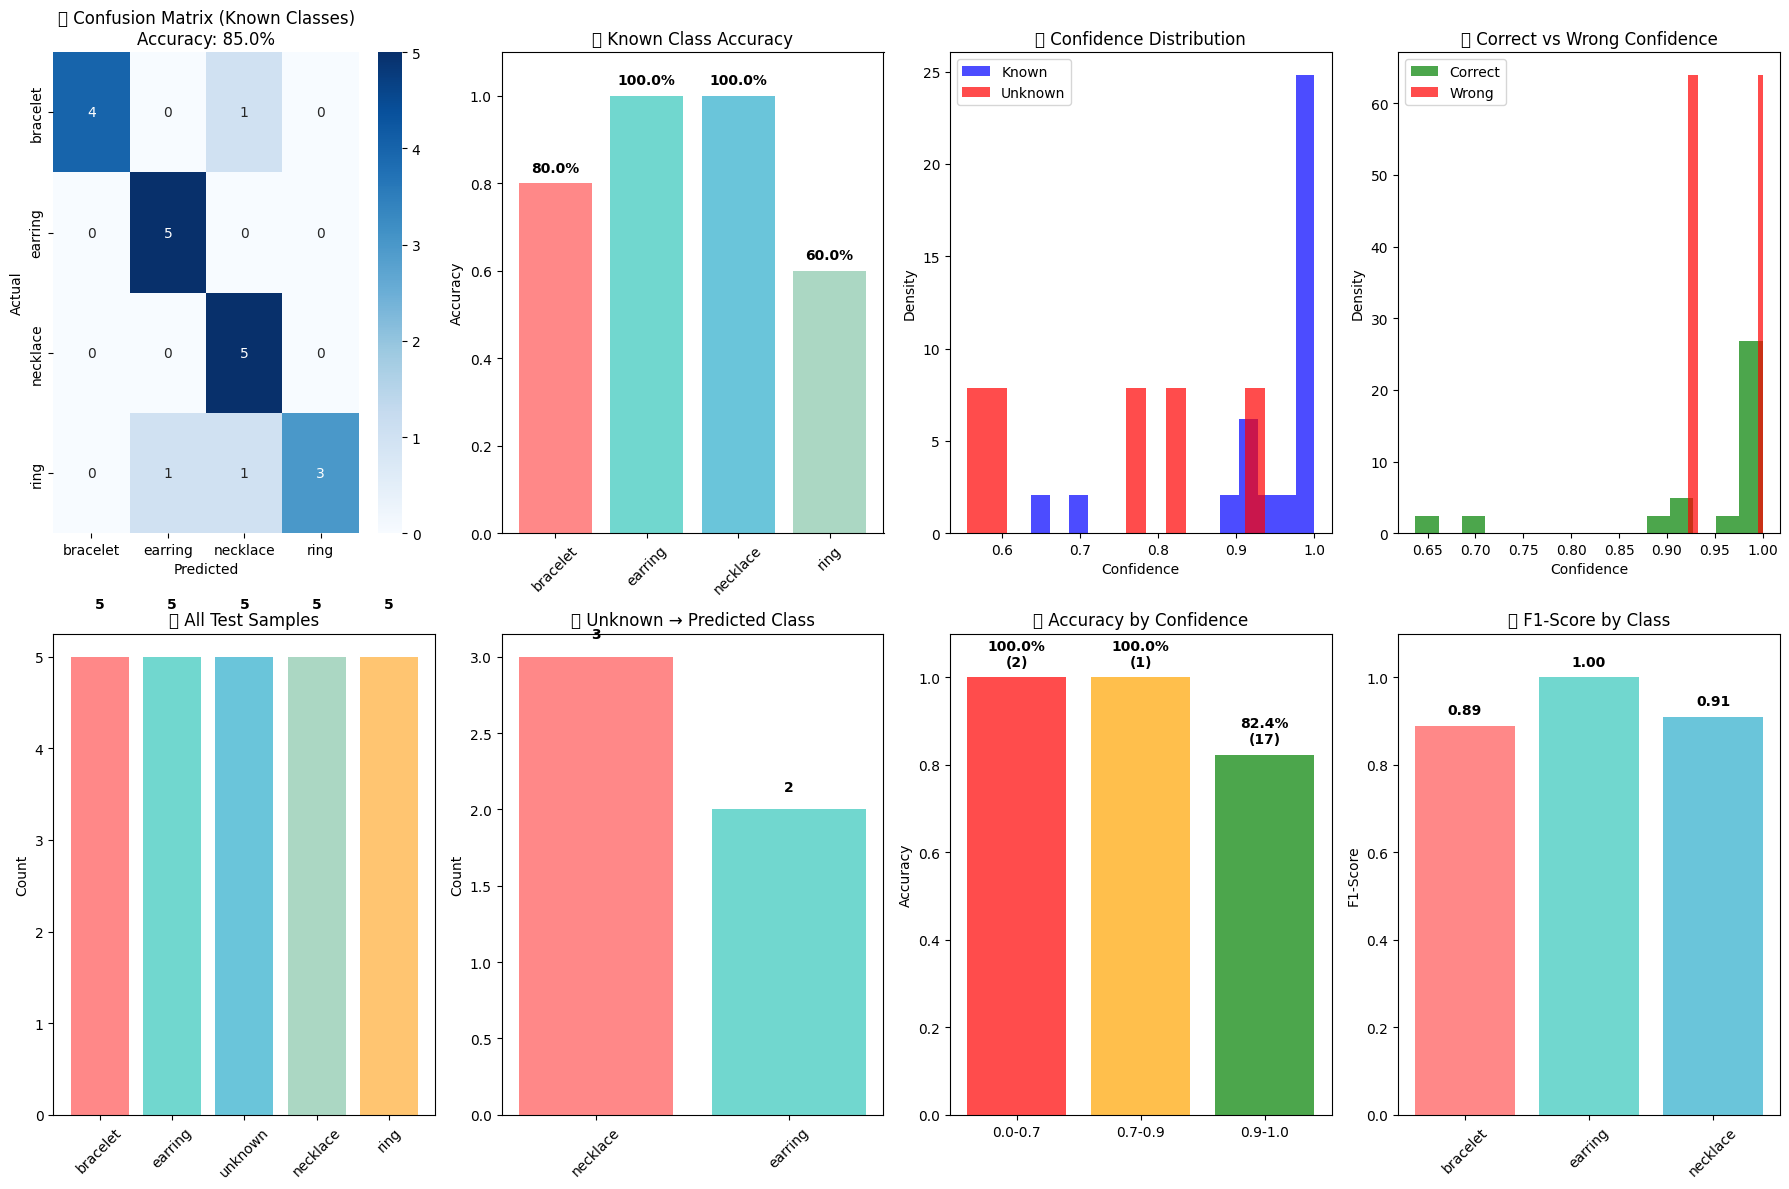


📋 상세 예측 결과:
----------------------------------------------------------------------------------------------------
파일명                                 실제           예측           신뢰도      결과        
----------------------------------------------------------------------------------------------------
🔍 Unknown 이미지 예측 결과:
error_01.jpeg                       unknown      necklace     0.590    🔍 Unknown 
error_02.jpeg                       unknown      necklace     0.829    🔍 Unknown 
error_03.jpeg                       unknown      earring      0.555    🔍 Unknown 
error_04.jpeg                       unknown      earring      0.771    🔍 Unknown 
error_05.jpeg                       unknown      necklace     0.937    🔍 Unknown 

❌ Known 클래스 오답 결과:
bracelet_04.jpeg                    bracelet     necklace     1.000    ❌ 틀림      
ring_02.jpeg                        ring         necklace     0.931    ❌ 틀림      
ring_03.jpeg                        ring         earring      0.922    ❌ 틀림      

✅ Kno

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torchvision import transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn 대신 수동으로 구현한 함수들 (sklearn 오류 방지)
def manual_confusion_matrix(y_true, y_pred, num_classes):
    """수동으로 confusion matrix 계산"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        if true < num_classes and pred < num_classes:  # 범위 체크
            cm[true][pred] += 1
    return cm

def manual_classification_report(y_true, y_pred, class_names=None):
    """수동으로 classification report 계산"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Unknown 클래스 제외하고 계산
    valid_mask = y_true < len(class_names) - 1 if class_names else True
    if isinstance(valid_mask, bool):
        valid_mask = np.ones(len(y_true), dtype=bool)
    
    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]
    
    num_classes = len(np.unique(y_true_valid)) if len(y_true_valid) > 0 else len(class_names) - 1
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    
    report = {}
    
    for i in range(min(num_classes, len(class_names) - 1)):  # Unknown 클래스 제외
        # True Positives, False Positives, False Negatives 계산
        tp = sum((y_true_valid == i) & (y_pred_valid == i))
        fp = sum((y_true_valid != i) & (y_pred_valid == i))
        fn = sum((y_true_valid == i) & (y_pred_valid != i))
        
        # Precision, Recall, F1-score 계산
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        report[class_names[i]] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': sum(y_true_valid == i)
        }
    
    # 전체 정확도 계산 (Unknown 제외)
    if len(y_true_valid) > 0:
        accuracy = sum(y_true_valid == y_pred_valid) / len(y_true_valid)
    else:
        accuracy = 0
    report['accuracy'] = accuracy
    
    return report

# sklearn 오류로 인해 수동 구현만 사용
print("⚠️ sklearn 호환성 문제로 인해 수동 구현 함수를 사용합니다.")
confusion_matrix = manual_confusion_matrix
classification_report = manual_classification_report
USE_SKLEARN = False

# 모델 클래스 정의
class MemoryEfficientClassifier(nn.Module):
    def __init__(self, num_classes=4, model_size='xlarge'):
        super(MemoryEfficientClassifier, self).__init__()

        model_configs = {
            'small': ['mobilenetv3_large_100.ra_in1k', 'efficientnet_b2.ra_in1k'],
            'medium': ['efficientnet_b3.ra2_in1k', 'efficientnet_b4.ra2_in1k'],
            'large': ['efficientnetv2_rw_m.agc_in1k', 'efficientnet_b5.ra_in1k'],
            'xlarge': ['efficientnetv2_m.in21k_ft_in1k', 'convnext_base.fb_in22k_ft_in1k', 'efficientnet_b6.ra_in1k']
        }

        self.backbone = None
        backbone_features = None

        for model_name in model_configs[model_size]:
            try:
                self.backbone = timm.create_model(model_name, pretrained=True)
                backbone_features = self.backbone.num_features
                self.backbone.classifier = nn.Identity()
                print(f"✅ 모델 로드: {model_name}")
                break
            except:
                continue

        if self.backbone is None:
            raise RuntimeError("모델을 로드할 수 없습니다.")

        # 분류기 헤드
        if model_size == 'small':
            hidden_size = 256
        elif model_size == 'medium':
            hidden_size = 512
        elif model_size == 'large':
            hidden_size = 768
        else:  # xlarge
            hidden_size = 1024

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(backbone_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)
        output = self.classifier(features)
        return output

def get_test_transform(image_size=320):
    """데이터 변환 정의"""
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def extract_class_from_filename(filename, class_names):
    """파일명에서 클래스명 추출 (Unknown 클래스 추가)"""
    filename_lower = filename.lower()
    
    # 각 클래스명이 파일명에 포함되어 있는지 확인
    for i, class_name in enumerate(class_names[:-1]):  # Unknown 클래스 제외
        if class_name.lower() in filename_lower:
            return i, class_name
    
    # 매칭되지 않을 경우 Unknown 클래스로 분류
    unknown_idx = len(class_names) - 1
    return unknown_idx, 'unknown'

def collect_test_images(test_dataset_path, class_names):
    """test_datasets 폴더에서 모든 이미지 파일 수집 (Unknown 포함)"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
    test_images = []
    
    if not os.path.exists(test_dataset_path):
        print(f"❌ 테스트 데이터셋 경로를 찾을 수 없습니다: {test_dataset_path}")
        return []
    
    print(f"📁 테스트 데이터셋 경로: {test_dataset_path}")
    
    # 모든 이미지 파일 찾기
    for root, dirs, files in os.walk(test_dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                full_path = os.path.join(root, file)
                
                # 파일명에서 클래스 추출 (Unknown 포함)
                true_class_idx, true_class_name = extract_class_from_filename(file, class_names)
                
                test_images.append({
                    'path': full_path,
                    'filename': file,
                    'true_class_idx': true_class_idx,
                    'true_class_name': true_class_name
                })
                
                if true_class_name == 'unknown':
                    print(f"🔍 Unknown 이미지 발견: {file}")
    
    # 클래스별 통계 출력
    class_counts = {}
    for img_info in test_images:
        class_name = img_info['true_class_name']
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    print(f"\n📊 클래스별 이미지 수:")
    for class_name, count in class_counts.items():
        if class_name == 'unknown':
            print(f"   {class_name}: {count}개 ⚠️")
        else:
            print(f"   {class_name}: {count}개")
    
    print(f"\n📋 총 테스트 이미지: {len(test_images)}개")
    
    return test_images

def predict_single_image_with_tta(model, image_path, transform, device, num_tta=5):
    """TTA를 적용한 단일 이미지 예측"""
    try:
        # 이미지 로드
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        model.eval()
        predictions = []

        with torch.no_grad():
            # 원본 이미지
            with autocast():
                outputs = model(image_tensor)
                predictions.append(F.softmax(outputs, dim=1))

            # TTA 변환들
            tta_transforms = [
                lambda x: torch.flip(x, dims=[3]),  # 수평 반전
                lambda x: torch.flip(x, dims=[2]),  # 수직 반전
                lambda x: torch.rot90(x, k=2, dims=[2, 3]),  # 180도 회전
                lambda x: x * 0.95 + 0.02,  # 밝기 조정
            ]

            for i, tta_transform in enumerate(tta_transforms[:num_tta-1]):
                try:
                    transformed = tta_transform(image_tensor.clone())
                    with autocast():
                        outputs = model(transformed)
                        predictions.append(F.softmax(outputs, dim=1))
                except:
                    continue

            # 평균 예측
            if predictions:
                avg_prediction = torch.mean(torch.stack(predictions), dim=0)
                predicted_class_idx = torch.argmax(avg_prediction, dim=1).item()
                confidence = avg_prediction[0][predicted_class_idx].item()
                class_probabilities = avg_prediction[0].cpu().numpy()

                return predicted_class_idx, confidence, class_probabilities

    except Exception as e:
        print(f"❌ 예측 오류 ({os.path.basename(image_path)}): {str(e)}")

    return None, 0.0, None

def analyze_unknown_predictions(detailed_results, class_names):
    """Unknown 이미지들에 대한 예측 분석"""
    unknown_results = [r for r in detailed_results if r['true_class'] == 'unknown']
    
    if not unknown_results:
        print("🔍 Unknown 이미지가 없습니다.")
        return
    
    print(f"\n🔍 Unknown 이미지 분석 ({len(unknown_results)}개):")
    print("-" * 80)
    
    # Unknown 이미지들의 예측 분포
    pred_distribution = {}
    confidence_list = []
    
    for result in unknown_results:
        pred_class = result['pred_class']
        confidence = result['confidence']
        
        pred_distribution[pred_class] = pred_distribution.get(pred_class, 0) + 1
        confidence_list.append(confidence)
    
    print("📊 Unknown 이미지들의 예측 분포:")
    for pred_class, count in pred_distribution.items():
        percentage = count / len(unknown_results) * 100
        print(f"   {pred_class}: {count}개 ({percentage:.1f}%)")
    
    print(f"\n📈 Unknown 이미지들의 신뢰도 분석:")
    print(f"   평균 신뢰도: {np.mean(confidence_list):.3f}")
    print(f"   최대 신뢰도: {np.max(confidence_list):.3f}")
    print(f"   최소 신뢰도: {np.min(confidence_list):.3f}")
    print(f"   신뢰도 표준편차: {np.std(confidence_list):.3f}")
    
    # 높은 신뢰도로 잘못 예측된 Unknown 이미지들
    high_conf_unknowns = [r for r in unknown_results if r['confidence'] > 0.8]
    if high_conf_unknowns:
        print(f"\n⚠️  높은 신뢰도(>0.8)로 예측된 Unknown 이미지들 ({len(high_conf_unknowns)}개):")
        for result in high_conf_unknowns:
            print(f"   {result['filename'][:40]:<40} → {result['pred_class']} (신뢰도: {result['confidence']:.3f})")
    
    return unknown_results

def evaluate_model_with_filename_labels(model_path, test_dataset_path, class_names=['bracelet', 'earring', 'necklace', 'ring', 'unknown']):
    """파일명 기준으로 모델 신뢰도 평가 (Unknown 클래스 포함)"""
    
    print("🔍 파일명 기준 모델 신뢰도 평가 시작 (Unknown 클래스 포함)")
    print("=" * 70)
    
    # GPU 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 사용 디바이스: {device}")
    
    # 모델 로드 (Unknown 클래스 제외한 개수로 로드)
    print(f"\n🤖 모델 로딩 중...")
    try:
        model = MemoryEfficientClassifier(num_classes=len(class_names)-1, model_size='xlarge')  # Unknown 제외
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        model.eval()
        print(f"✅ 모델 로드 성공: {model_path}")
        print(f"📋 모델 클래스 수: {len(class_names)-1} (Unknown 제외)")
    except Exception as e:
        print(f"❌ 모델 로드 실패: {str(e)}")
        return
    
    # 테스트 이미지 수집
    print(f"\n📁 테스트 이미지 수집 중...")
    test_images = collect_test_images(test_dataset_path, class_names)
    
    if not test_images:
        print("❌ 테스트할 이미지를 찾을 수 없습니다.")
        return
    
    # 데이터 변환
    transform = get_test_transform(320)
    
    # 예측 실행
    print(f"\n🎯 예측 테스트 실행 중...")
    print("=" * 80)
    
    all_predictions = []
    all_true_labels = []
    detailed_results = []
    
    for i, img_info in enumerate(test_images):
        image_path = img_info['path']
        true_class_idx = img_info['true_class_idx']
        true_class_name = img_info['true_class_name']
        filename = img_info['filename']
        
        # 예측 수행
        pred_class_idx, confidence, class_probs = predict_single_image_with_tta(
            model, image_path, transform, device
        )
        
        if pred_class_idx is not None:
            # Unknown 클래스가 아닌 경우에만 예측 클래스명 할당
            if pred_class_idx < len(class_names) - 1:
                pred_class_name = class_names[pred_class_idx]
            else:
                pred_class_name = 'unknown'
            
            # 정답 여부 판정 (Unknown은 모델이 예측할 수 없으므로 별도 처리)
            if true_class_name == 'unknown':
                is_correct = False  # Unknown은 정답/오답 판정하지 않음
                correctness_type = 'unknown'
            else:
                is_correct = pred_class_idx == true_class_idx
                correctness_type = 'correct' if is_correct else 'wrong'
            
            # 결과 저장
            all_predictions.append(pred_class_idx)
            all_true_labels.append(true_class_idx)
            
            detailed_results.append({
                'filename': filename,
                'true_class': true_class_name,
                'pred_class': pred_class_name,
                'confidence': confidence,
                'correct': is_correct,
                'correctness_type': correctness_type,
                'class_probs': class_probs
            })
            
            # 진행상황 출력 (10개마다)
            if (i + 1) % 10 == 0 or (i + 1) == len(test_images):
                if true_class_name == 'unknown':
                    status = "🔍 Unknown"
                else:
                    status = "✅ 정답" if is_correct else "❌ 오답"
                print(f"   [{i+1:3d}/{len(test_images)}] {filename[:30]:<30} "
                      f"실제:{true_class_name:<10} 예측:{pred_class_name:<10} "
                      f"신뢰도:{confidence:.3f} {status}")
    
    # 결과 분석 및 시각화
    print(f"\n📊 테스트 결과 분석")
    print("=" * 60)
    
    if all_predictions and all_true_labels:
        # Known 클래스들만 대상으로 정확도 계산
        known_results = [r for r in detailed_results if r['true_class'] != 'unknown']
        known_predictions = [r['pred_class'] == r['true_class'] for r in known_results]
        
        if known_results:
            known_accuracy = np.mean(known_predictions)
            print(f"🎯 Known 클래스 정확도: {known_accuracy:.1%} ({sum(known_predictions)}/{len(known_results)})")
        
        # 전체 통계
        print(f"📈 전체 통계:")
        print(f"   총 테스트 이미지: {len(detailed_results)}개")
        print(f"   Known 클래스: {len(known_results)}개")
        print(f"   Unknown 클래스: {len(detailed_results) - len(known_results)}개")
        
        # 클래스별 정확도 (Known만)
        print(f"\n📈 Known 클래스별 정확도:")
        class_accuracies = {}
        for class_idx, class_name in enumerate(class_names[:-1]):  # Unknown 제외
            class_results = [r for r in known_results if r['true_class'] == class_name]
            if class_results:
                class_acc = np.mean([r['correct'] for r in class_results])
                class_accuracies[class_name] = class_acc
                print(f"   {class_name:<12}: {class_acc:.1%} (테스트 샘플: {len(class_results)}개)")
        
        # 신뢰도 분석
        all_confidences = [result['confidence'] for result in detailed_results]
        known_confidences = [result['confidence'] for result in known_results]
        unknown_confidences = [result['confidence'] for result in detailed_results if result['true_class'] == 'unknown']
        correct_confidences = [result['confidence'] for result in known_results if result['correct']]
        wrong_confidences = [result['confidence'] for result in known_results if not result['correct']]
        
        print(f"\n🔍 신뢰도 분석:")
        print(f"   전체 평균 신뢰도: {np.mean(all_confidences):.3f}")
        if known_confidences:
            print(f"   Known 클래스 평균 신뢰도: {np.mean(known_confidences):.3f}")
        if unknown_confidences:
            print(f"   Unknown 클래스 평균 신뢰도: {np.mean(unknown_confidences):.3f}")
        if correct_confidences:
            print(f"   정답 평균 신뢰도: {np.mean(correct_confidences):.3f}")
        if wrong_confidences:
            print(f"   오답 평균 신뢰도: {np.mean(wrong_confidences):.3f}")
        
        # Unknown 이미지 분석
        analyze_unknown_predictions(detailed_results, class_names)
        
        # 혼동 행렬 계산 (Known 클래스만)
        known_true_labels = [class_names.index(r['true_class']) for r in known_results]
        known_pred_labels = [class_names.index(r['pred_class']) for r in known_results if r['pred_class'] in class_names[:-1]]
        
        # 시각화
        plt.figure(figsize=(18, 12))
        
        # 1. 혼동 행렬 (Known 클래스만)
        plt.subplot(2, 4, 1)
        if known_true_labels and len(known_pred_labels) == len(known_true_labels):
            cm = confusion_matrix(known_true_labels, known_pred_labels, len(class_names)-1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_names[:-1], yticklabels=class_names[:-1])
            plt.title(f'🎯 Confusion Matrix (Known Classes)\nAccuracy: {known_accuracy:.1%}')
        else:
            plt.text(0.5, 0.5, 'No Known Class\nPredictions', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('🎯 Confusion Matrix (Known Classes)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 2. 클래스별 정확도
        plt.subplot(2, 4, 2)
        if class_accuracies:
            classes = list(class_accuracies.keys())
            accuracies = list(class_accuracies.values())
            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
            
            bars = plt.bar(classes, accuracies, color=colors[:len(classes)], alpha=0.8)
            plt.title('📈 Known Class Accuracy')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1.1)
            plt.xticks(rotation=45)
            
            for bar, acc in zip(bars, accuracies):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')
        
        # 3. 신뢰도 분포 (Known vs Unknown)
        plt.subplot(2, 4, 3)
        if known_confidences:
            plt.hist(known_confidences, bins=15, alpha=0.7, label='Known', color='blue', density=True)
        if unknown_confidences:
            plt.hist(unknown_confidences, bins=15, alpha=0.7, label='Unknown', color='red', density=True)
        plt.title('🔍 Confidence Distribution')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()
        
        # 4. 정답/오답 신뢰도 분포
        plt.subplot(2, 4, 4)
        if correct_confidences:
            plt.hist(correct_confidences, bins=15, alpha=0.7, label='Correct', color='green', density=True)
        if wrong_confidences:
            plt.hist(wrong_confidences, bins=15, alpha=0.7, label='Wrong', color='red', density=True)
        plt.title('🔍 Correct vs Wrong Confidence')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()
        
        # 5. 전체 클래스별 샘플 수 (Unknown 포함)
        plt.subplot(2, 4, 5)
        all_class_counts = {}
        for result in detailed_results:
            class_name = result['true_class']
            all_class_counts[class_name] = all_class_counts.get(class_name, 0) + 1
        
        classes = list(all_class_counts.keys())
        counts = list(all_class_counts.values())
        colors_extended = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFB74D']
        
        bars = plt.bar(classes, counts, color=colors_extended[:len(classes)], alpha=0.8)
        plt.title('📊 All Test Samples')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(count), ha='center', va='bottom', fontweight='bold')
        
        # 6. Unknown 예측 분포
        plt.subplot(2, 4, 6)
        unknown_results = [r for r in detailed_results if r['true_class'] == 'unknown']
        if unknown_results:
            unknown_pred_counts = {}
            for result in unknown_results:
                pred_class = result['pred_class']
                unknown_pred_counts[pred_class] = unknown_pred_counts.get(pred_class, 0) + 1
            
            pred_classes = list(unknown_pred_counts.keys())
            pred_counts = list(unknown_pred_counts.values())
            
            bars = plt.bar(pred_classes, pred_counts, color=colors_extended[:len(pred_classes)], alpha=0.8)
            plt.title('🔍 Unknown → Predicted Class')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            
            for bar, count in zip(bars, pred_counts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        str(count), ha='center', va='bottom', fontweight='bold')
        
        # 7. 신뢰도별 정확도 (Known만)
        plt.subplot(2, 4, 7)
        if known_confidences:
            confidence_ranges = [(0.0, 0.7), (0.7, 0.9), (0.9, 1.0)]
            range_accuracies = []
            range_labels = []
            range_counts = []
            
            for low, high in confidence_ranges:
                mask = [(low <= conf < high) for conf in known_confidences]
                count = sum(mask)
                if count > 0:
                    range_results = [known_results[i] for i, m in enumerate(mask) if m]
                    range_acc = np.mean([r['correct'] for r in range_results])
                    range_accuracies.append(range_acc)
                    range_counts.append(count)
                else:
                    range_accuracies.append(0)
                    range_counts.append(0)
                range_labels.append(f'{low:.1f}-{high:.1f}')
            
            bars = plt.bar(range_labels, range_accuracies, color=['red', 'orange', 'green'], alpha=0.7)
            plt.title('🎯 Accuracy by Confidence')
            plt.ylabel('Accuracy')
            plt.ylim(0, 1.1)
            
            for i, (acc, count) in enumerate(zip(range_accuracies, range_counts)):
                plt.text(i, acc + 0.02, f'{acc:.1%}\n({count})', ha='center', va='bottom', fontweight='bold')
        
        # 8. F1-Score (Known만)
        plt.subplot(2, 4, 8)
        if known_true_labels and known_pred_labels:
            report = classification_report(known_true_labels, known_pred_labels, class_names[:-1])
            f1_scores = [report[class_name]['f1-score'] for class_name in class_names[:-1] if class_name in report]
            
            if f1_scores:
                bars = plt.bar(class_names[:len(f1_scores)], f1_scores, color=colors[:len(f1_scores)], alpha=0.8)
                plt.title('🎯 F1-Score by Class')
                plt.ylabel('F1-Score')
                plt.ylim(0, 1.1)
                plt.xticks(rotation=45)
                
                for bar, f1 in zip(bars, f1_scores):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                            f'{f1:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 상세 결과 출력
        print(f"\n📋 상세 예측 결과:")
        print("-" * 100)
        print(f"{'파일명':<35} {'실제':<12} {'예측':<12} {'신뢰도':<8} {'결과':<10}")
        print("-" * 100)
        
        # Unknown 결과 먼저 출력
        unknown_results = [r for r in detailed_results if r['true_class'] == 'unknown']
        known_wrong_results = [r for r in detailed_results if r['true_class'] != 'unknown' and not r['correct']]
        known_correct_results = [r for r in detailed_results if r['true_class'] != 'unknown' and r['correct']]
        
        # Unknown 결과
        if unknown_results:
            print("🔍 Unknown 이미지 예측 결과:")
            for result in unknown_results:
                print(f"{result['filename']:<35} {result['true_class']:<12} {result['pred_class']:<12} "
                      f"{result['confidence']:<8.3f} {'🔍 Unknown':<10}")
        
        # 오답 결과 (Known만)
        if known_wrong_results:
            print("\n❌ Known 클래스 오답 결과:")
            for result in known_wrong_results:
                print(f"{result['filename']:<35} {result['true_class']:<12} {result['pred_class']:<12} "
                      f"{result['confidence']:<8.3f} {'❌ 틀림':<10}")
        
        # 몇 개 정답 결과도 보여주기 (최대 10개)
        if known_correct_results:
            print("\n✅ Known 클래스 정답 결과 (일부):")
            for result in known_correct_results[:10]:
                print(f"{result['filename']:<35} {result['true_class']:<12} {result['pred_class']:<12} "
                      f"{result['confidence']:<8.3f} {'✅ 맞음':<10}")
            
            if len(known_correct_results) > 10:
                print(f"   ... 그 외 {len(known_correct_results) - 10}개 정답 결과 생략")
        
        # 성능 요약
        print(f"\n🏆 성능 요약:")
        print(f"   총 테스트 샘플: {len(detailed_results)}개")
        print(f"   Known 클래스: {len(known_results)}개")
        print(f"   Unknown 클래스: {len(unknown_results)}개")
        if known_results:
            print(f"   Known 클래스 정답: {len(known_correct_results)}개")
            print(f"   Known 클래스 오답: {len(known_wrong_results)}개")
            print(f"   Known 클래스 정확도: {known_accuracy:.1%}")
        print(f"   전체 평균 신뢰도: {np.mean(all_confidences):.3f}")
        
        # 신뢰도별 분석
        if known_results:
            high_conf_correct = sum(1 for r in known_results if r['confidence'] > 0.9 and r['correct'])
            high_conf_total = sum(1 for r in known_results if r['confidence'] > 0.9)
            if high_conf_total > 0:
                print(f"   Known 고신뢰도(>0.9) 정확도: {high_conf_correct/high_conf_total:.1%} ({high_conf_correct}/{high_conf_total})")
        
        if unknown_results:
            high_conf_unknown = sum(1 for r in unknown_results if r['confidence'] > 0.9)
            print(f"   Unknown 고신뢰도(>0.9) 예측: {high_conf_unknown}개 ({high_conf_unknown/len(unknown_results)*100:.1f}%)")
            
            # Unknown에 대한 예측 신뢰도가 높은 경우 경고
            if high_conf_unknown > 0:
                print(f"   ⚠️  모델이 Unknown 이미지를 높은 신뢰도로 잘못 분류하고 있습니다!")
        
        # 모델 신뢰성 평가
        print(f"\n🔬 모델 신뢰성 평가:")
        if unknown_results:
            avg_unknown_confidence = np.mean(unknown_confidences)
            if known_results:
                avg_known_confidence = np.mean(known_confidences)
                confidence_gap = avg_known_confidence - avg_unknown_confidence
                print(f"   Known vs Unknown 신뢰도 차이: {confidence_gap:.3f}")
                
                if confidence_gap > 0.2:
                    print("   ✅ 모델이 Unknown 이미지에 대해 상대적으로 낮은 신뢰도를 보입니다. (좋은 신호)")
                elif confidence_gap > 0.05:
                    print("   ⚠️  모델이 Unknown 이미지에 대해 약간 낮은 신뢰도를 보입니다.")
                else:
                    print("   ❌ 모델이 Unknown 이미지에 대해서도 높은 신뢰도를 보입니다. (위험한 신호)")
        
        return known_accuracy if known_results else None, class_accuracies, detailed_results
    
    return None, None, None

def main():
    """메인 실행 함수"""
    
    print("🔍 파일명 기준 모델 신뢰도 평가 (Unknown 클래스 포함)")
    print("=" * 70)
    
    # 경로 설정 (실제 경로로 변경해주세요)
    model_path = 'C:\\Users\\yug67\\develope\\위드위\\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\\memory_optimized_best_model.pth'
    test_dataset_path = 'C:\\Users\\yug67\\develope\\위드위\\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\\test_datasets'
    
    # 클래스명 정의 (파일명에서 찾을 키워드들 + unknown)
    class_names = ['bracelet', 'earring', 'necklace', 'ring', 'unknown']
    
    # 경로 확인
    if not os.path.exists(model_path):
        print(f"❌ 모델 파일을 찾을 수 없습니다: {model_path}")
        return
    
    if not os.path.exists(test_dataset_path):
        print(f"❌ 테스트 데이터셋 경로를 찾을 수 없습니다: {test_dataset_path}")
        return
    
    try:
        # 평가 실행
        overall_acc, class_accs, results = evaluate_model_with_filename_labels(
            model_path=model_path,
            test_dataset_path=test_dataset_path,
            class_names=class_names
        )
        
        if overall_acc is not None:
            print(f"\n🎉 평가 완료!")
            print(f"📈 Known 클래스 달성 성능: {overall_acc:.1%}")
            
            # 성능 등급
            if overall_acc >= 0.95:
                print("🏆 우수한 성능!")
            elif overall_acc >= 0.90:
                print("👍 좋은 성능!")
            elif overall_acc >= 0.80:
                print("👌 양호한 성능")
            else:
                print("📈 개선 여지 있음")
        
        # Unknown 이미지에 대한 추가 분석 결과 제공
        if results:
            unknown_count = len([r for r in results if r['true_class'] == 'unknown'])
            if unknown_count > 0:
                print(f"\n🔍 Unknown 이미지 처리 결과:")
                print(f"   총 {unknown_count}개의 Unknown 이미지 테스트됨")
                unknown_confidences = [r['confidence'] for r in results if r['true_class'] == 'unknown']
                high_conf_unknown = sum(1 for conf in unknown_confidences if conf > 0.8)
                print(f"   높은 신뢰도(>0.8)로 예측된 Unknown: {high_conf_unknown}개")
                
                if high_conf_unknown == 0:
                    print("   ✅ 모든 Unknown 이미지에 대해 낮은 신뢰도로 예측했습니다!")
                elif high_conf_unknown / unknown_count < 0.2:
                    print("   👍 대부분의 Unknown 이미지에 대해 적절한 신뢰도를 보입니다.")
                else:
                    print("   ⚠️  일부 Unknown 이미지에 대해 과도한 신뢰도를 보입니다. 모델 튜닝 필요!")
    
    except Exception as e:
        print(f"❌ 평가 중 오류 발생: {str(e)}")
        import traceback
        traceback.print_exc()
    
    finally:
        # 메모리 정리
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"\n🧹 메모리 정리 완료")

# 추가로 Unknown 이미지에 대한 개별 분석 함수
def analyze_single_unknown_image(model_path, image_path, class_names=['bracelet', 'earring', 'necklace', 'ring']):
    """단일 Unknown 이미지에 대한 상세 분석"""
    
    print(f"🔍 Unknown 이미지 개별 분석: {os.path.basename(image_path)}")
    print("-" * 50)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 모델 로드
    model = MemoryEfficientClassifier(num_classes=len(class_names), model_size='xlarge')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    
    transform = get_test_transform(320)
    pred_idx, confidence, probs = predict_single_image_with_tta(model, image_path, transform, device)
    
    if pred_idx is not None:
        pred_class = class_names[pred_idx]
        print(f"🎯 예측 결과:")
        print(f"   예측 클래스: {pred_class}")
        print(f"   신뢰도: {confidence:.3f}")
        print(f"   모든 클래스 확률:")
        
        # 확률 순으로 정렬
        prob_pairs = list(zip(class_names, probs))
        prob_pairs.sort(key=lambda x: x[1], reverse=True)
        
        for i, (class_name, prob) in enumerate(prob_pairs):
            marker = "👑" if i == 0 else f"{i+1}."
            print(f"     {marker} {class_name}: {prob:.3f}")
        
        # 신뢰도 경고
        if confidence > 0.9:
            print(f"\n⚠️  매우 높은 신뢰도! 모델이 Unknown 이미지를 확신하고 있습니다.")
        elif confidence > 0.7:
            print(f"\n⚠️  높은 신뢰도. 모델이 이 이미지를 해당 클래스로 분류하고 있습니다.")
        else:
            print(f"\n✅ 적절한 신뢰도. 모델이 불확실성을 보이고 있습니다.")

if __name__ == "__main__":
    main()

In [6]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

# 모델 평가 함수
def evaluate_single_image(model, image_path, class_names, device='cpu'):
    """
    단일 이미지에 대해 분류 모델을 평가하는 함수
    
    Args:
        model: 훈련된 PyTorch 모델
        image_path: 평가할 이미지 경로
        class_names: 클래스 이름 리스트
        device: 연산 장치 ('cpu' 또는 'cuda')
    
    Returns:
        predicted_class: 예측된 클래스
        confidence: 예측 확신도
        all_probabilities: 모든 클래스에 대한 확률
    """
    
    # 모델을 평가 모드로 설정
    model.eval()
    model.to(device)
    
    # 이미지 전처리 파이프라인
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 모델 입력 크기에 맞게 조정
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])  # ImageNet 정규화
    ])
    
    # 이미지 로드 및 전처리
    try:
        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0)  # 배치 차원 추가
        input_tensor = input_tensor.to(device)
        
        # 추론 수행 (gradient 계산 비활성화)
        with torch.no_grad():
            outputs = model(input_tensor)
            
            # Softmax를 적용하여 확률로 변환
            probabilities = F.softmax(outputs, dim=1)
            
            # 가장 높은 확률의 클래스 예측
            predicted_idx = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_idx].item()
            
            # 모든 클래스의 확률
            all_probs = probabilities[0].cpu().numpy()
            
        return predicted_idx, confidence, all_probs
        
    except Exception as e:
        print(f"이미지 처리 중 오류 발생: {e}")
        return None, None, None

# 결과를 보기 좋게 출력하는 함수
def print_prediction_results(predicted_idx, confidence, all_probs, class_names, top_k=3):
    """
    예측 결과를 보기 좋게 출력
    
    Args:
        predicted_idx: 예측된 클래스 인덱스
        confidence: 예측 확신도
        all_probs: 모든 클래스 확률
        class_names: 클래스 이름 리스트
        top_k: 상위 k개 결과 표시
    """
    
    if predicted_idx is None:
        print("예측 실패")
        return
    
    print("=" * 50)
    print("🎯 예측 결과")
    print("=" * 50)
    print(f"예측 클래스: {class_names[predicted_idx]}")
    print(f"확신도: {confidence:.4f} ({confidence*100:.2f}%)")
    print()
    
    # Top-K 결과 표시
    top_indices = np.argsort(all_probs)[::-1][:top_k]
    print(f"📊 Top-{top_k} 예측:")
    print("-" * 30)
    
    for i, idx in enumerate(top_indices, 1):
        print(f"{i}. {class_names[idx]}: {all_probs[idx]:.4f} ({all_probs[idx]*100:.2f}%)")

# 모델 클래스 정의 (일반적인 CNN 분류기 구조)
import torch.nn as nn

class MemoryEfficientClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(MemoryEfficientClassifier, self).__init__()
        
        # 일반적인 CNN 구조 (실제 모델 구조에 맞게 수정 필요)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 저장된 모델 정보를 분석하는 함수
def analyze_saved_model(model_path):
    """저장된 모델의 구조를 분석합니다."""
    try:
        checkpoint = torch.load(model_path, map_location='cpu')
        
        if isinstance(checkpoint, dict):
            print("📊 저장된 모델 정보:")
            print(f"  - 타입: {type(checkpoint)}")
            
            if 'state_dict' in checkpoint:
                print("  - 'state_dict' 키가 있습니다")
                state_dict = checkpoint['state_dict']
            elif isinstance(checkpoint, dict) and all(isinstance(k, str) for k in checkpoint.keys()):
                print("  - state_dict 형태의 딕셔너리입니다")
                state_dict = checkpoint
            else:
                print("  - 알 수 없는 형태입니다")
                return None
            
            # 레이어 정보 출력
            print("  - 레이어 정보:")
            for i, (name, param) in enumerate(state_dict.items()):
                if i < 10:  # 처음 10개만 출력
                    print(f"    {name}: {param.shape}")
                elif i == 10:
                    print(f"    ... (총 {len(state_dict)}개 레이어)")
                    break
            
            return state_dict
        else:
            print(f"📊 저장된 모델 타입: {type(checkpoint)}")
            return checkpoint
            
    except Exception as e:
        print(f"❌ 모델 분석 실패: {e}")
        return None

# 사용 예제
def main():
    model_path = 'memory_optimized_best_model.pth'
    
    print("🔍 모델 파일 분석 중...")
    checkpoint = analyze_saved_model(model_path)
    
    if checkpoint is None:
        print("❌ 모델 로드 실패")
        return
    
    try:
        # state_dict 형태인지 확인
        if isinstance(checkpoint, dict) and not hasattr(checkpoint, 'eval'):
            print("📦 state_dict 형태로 저장된 모델입니다.")
            
            # 모델 인스턴스 생성
            model = MemoryEfficientClassifier(num_classes=4)
            
            # state_dict 로드 시도
            try:
                model.load_state_dict(checkpoint, strict=False)
                print("✅ state_dict가 성공적으로 로드되었습니다.")
            except RuntimeError as e:
                print(f"⚠️ state_dict 로드 중 경고: {e}")
                print("🔄 strict=False로 부분 로드를 시도합니다...")
                model.load_state_dict(checkpoint, strict=False)
                
        else:
            # 전체 모델이 저장된 경우
            model = checkpoint
            print("✅ 전체 모델이 성공적으로 로드되었습니다.")
        
    except Exception as e:
        print(f"❌ 모델 로드 실패: {e}")
        print("\n💡 해결방법:")
        print("1. 실제 모델 클래스 정의가 필요할 수 있습니다")
        print("2. 모델이 다른 구조로 저장되었을 수 있습니다")
        print("3. PyTorch 버전 호환성 문제일 수 있습니다")
        return
    
    # 2. 클래스 이름 정의 (주얼리 분류)
    class_names = ['bracelet', 'earring', 'necklace', 'ring']
    
    # 3. 장치 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ 사용 장치: {device}")
    
    # 4. 이미지 경로
    image_path = r'C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets\bracelet_02.jpeg'
    
    # 이미지 파일 존재 확인
    import os
    if not os.path.exists(image_path):
        print(f"❌ 이미지 파일을 찾을 수 없습니다: {image_path}")
        return
    
    print(f"📸 이미지 경로: {image_path}")
    
    # 5. 예측 수행
    try:
        predicted_idx, confidence, all_probs = evaluate_single_image(
            model, image_path, class_names, device
        )
        
        # 6. 결과 출력
        print_prediction_results(predicted_idx, confidence, all_probs, class_names)
        
    except Exception as e:
        print(f"❌ 예측 실행 중 오류: {e}")
        print("\n💡 가능한 원인:")
        print("- 모델 구조가 실제와 다를 수 있습니다")
        print("- 이미지 전처리 설정이 훈련시와 다를 수 있습니다")
        print("- 입력 텐서 크기가 맞지 않을 수 있습니다")

# 추가: 배치 처리를 위한 함수
def evaluate_multiple_images(model, image_paths, class_names, device='cpu'):
    """
    여러 이미지를 한 번에 평가하는 함수
    """
    model.eval()
    model.to(device)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    results = []
    
    for image_path in image_paths:
        try:
            image = Image.open(image_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(input_tensor)
                probabilities = F.softmax(outputs, dim=1)
                predicted_idx = torch.argmax(probabilities, dim=1).item()
                confidence = probabilities[0][predicted_idx].item()
                
            results.append({
                'image_path': image_path,
                'predicted_class': class_names[predicted_idx],
                'confidence': confidence
            })
            
        except Exception as e:
            results.append({
                'image_path': image_path,
                'predicted_class': 'Error',
                'confidence': 0.0,
                'error': str(e)
            })
    
    return results

if __name__ == "__main__":
    main()

🔍 모델 파일 분석 중...
📊 저장된 모델 정보:
  - 타입: <class 'collections.OrderedDict'>
  - state_dict 형태의 딕셔너리입니다
  - 레이어 정보:
    backbone.stem.0.weight: torch.Size([128, 3, 4, 4])
    backbone.stem.0.bias: torch.Size([128])
    backbone.stem.1.weight: torch.Size([128])
    backbone.stem.1.bias: torch.Size([128])
    backbone.stages.0.blocks.0.gamma: torch.Size([128])
    backbone.stages.0.blocks.0.conv_dw.weight: torch.Size([128, 1, 7, 7])
    backbone.stages.0.blocks.0.conv_dw.bias: torch.Size([128])
    backbone.stages.0.blocks.0.norm.weight: torch.Size([128])
    backbone.stages.0.blocks.0.norm.bias: torch.Size([128])
    backbone.stages.0.blocks.0.mlp.fc1.weight: torch.Size([512, 128])
    ... (총 360개 레이어)
📦 state_dict 형태로 저장된 모델입니다.
✅ state_dict가 성공적으로 로드되었습니다.
🖥️ 사용 장치: cpu
📸 이미지 경로: C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets\bracelet_02.jpeg
🎯 예측 결과
예측 클래스: bracelet
확신도: 0.3008 (30.08%)

📊 Top-3 예측:
------------------------------
1. bracelet: 0.3008 (30.08%)
2. nec

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import timm

# 모델 클래스 정의 (원본 모델 구조)
class MemoryEfficientClassifier(nn.Module):
    def __init__(self, num_classes=4, model_size='xlarge'):
        super(MemoryEfficientClassifier, self).__init__()

        model_configs = {
            'small': ['mobilenetv3_large_100.ra_in1k', 'efficientnet_b2.ra_in1k'],
            'medium': ['efficientnet_b3.ra2_in1k', 'efficientnet_b4.ra2_in1k'],
            'large': ['efficientnetv2_rw_m.agc_in1k', 'efficientnet_b5.ra_in1k'],
            'xlarge': ['efficientnetv2_m.in21k_ft_in1k', 'convnext_base.fb_in22k_ft_in1k', 'efficientnet_b6.ra_in1k']
        }

        self.backbone = None
        backbone_features = None

        for model_name in model_configs[model_size]:
            try:
                self.backbone = timm.create_model(model_name, pretrained=True)
                backbone_features = self.backbone.num_features
                self.backbone.classifier = nn.Identity()
                print(f"✅ 모델 백본 로드: {model_name}")
                break
            except:
                continue

        if self.backbone is None:
            raise RuntimeError("모델을 로드할 수 없습니다.")

        # 분류기 헤드
        if model_size == 'small':
            hidden_size = 256
        elif model_size == 'medium':
            hidden_size = 512
        elif model_size == 'large':
            hidden_size = 768
        else:  # xlarge
            hidden_size = 1024

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(backbone_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)
        output = self.classifier(features)
        return output

def get_test_transform(image_size=320):
    """이미지 전처리 변환"""
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def predict_single_image_with_tta(model, image_path, transform, device, num_tta=5):
    """TTA(Test Time Augmentation)를 적용한 단일 이미지 예측"""
    try:
        # 이미지 로드
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        model.eval()
        predictions = []

        with torch.no_grad():
            # 원본 이미지 예측
            with autocast():
                outputs = model(image_tensor)
                predictions.append(F.softmax(outputs, dim=1))

            # TTA 변환들
            tta_transforms = [
                lambda x: torch.flip(x, dims=[3]),  # 수평 반전
                lambda x: torch.flip(x, dims=[2]),  # 수직 반전
                lambda x: torch.rot90(x, k=2, dims=[2, 3]),  # 180도 회전
                lambda x: x * 0.95 + 0.02,  # 밝기 조정
            ]

            # TTA 적용
            for i, tta_transform in enumerate(tta_transforms[:num_tta-1]):
                try:
                    transformed = tta_transform(image_tensor.clone())
                    with autocast():
                        outputs = model(transformed)
                        predictions.append(F.softmax(outputs, dim=1))
                except:
                    continue

            # 평균 예측
            if predictions:
                avg_prediction = torch.mean(torch.stack(predictions), dim=0)
                predicted_class_idx = torch.argmax(avg_prediction, dim=1).item()
                confidence = avg_prediction[0][predicted_class_idx].item()
                class_probabilities = avg_prediction[0].cpu().numpy()

                return predicted_class_idx, confidence, class_probabilities

    except Exception as e:
        print(f"❌ 예측 오류 ({os.path.basename(image_path)}): {str(e)}")

    return None, 0.0, None

def evaluate_single_image(model, image_path, class_names, device='cpu', use_tta=True):
    """
    단일 이미지에 대해 분류 모델을 평가하는 함수
    
    Args:
        model: 훈련된 PyTorch 모델
        image_path: 평가할 이미지 경로
        class_names: 클래스 이름 리스트
        device: 연산 장치 ('cpu' 또는 'cuda')
        use_tta: TTA 사용 여부
    
    Returns:
        predicted_idx: 예측된 클래스 인덱스
        confidence: 예측 확신도
        all_probabilities: 모든 클래스에 대한 확률
    """
    
    # 모델을 평가 모드로 설정
    model.eval()
    model.to(device)
    
    # 이미지 전처리
    transform = get_test_transform(320)
    
    if use_tta:
        # TTA를 사용한 예측
        predicted_idx, confidence, all_probs = predict_single_image_with_tta(
            model, image_path, transform, device
        )
    else:
        # 일반 예측
        try:
            image = Image.open(image_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                with autocast():
                    outputs = model(input_tensor)
                    probabilities = F.softmax(outputs, dim=1)
                    
                    predicted_idx = torch.argmax(probabilities, dim=1).item()
                    confidence = probabilities[0][predicted_idx].item()
                    all_probs = probabilities[0].cpu().numpy()
                    
        except Exception as e:
            print(f"❌ 이미지 처리 중 오류 발생: {e}")
            return None, None, None
    
    return predicted_idx, confidence, all_probs

def print_prediction_results(predicted_idx, confidence, all_probs, class_names, top_k=3):
    """예측 결과를 보기 좋게 출력"""
    
    if predicted_idx is None:
        print("❌ 예측 실패")
        return
    
    print("=" * 60)
    print("🎯 예측 결과")
    print("=" * 60)
    print(f"📸 예측 클래스: {class_names[predicted_idx]}")
    print(f"🔍 확신도: {confidence:.4f} ({confidence*100:.2f}%)")
    print()
    
    # Top-K 결과 표시
    top_indices = np.argsort(all_probs)[::-1][:top_k]
    print(f"📊 Top-{top_k} 예측 결과:")
    print("-" * 40)
    
    for i, idx in enumerate(top_indices, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
        print(f"{emoji} {class_names[idx]}: {all_probs[idx]:.4f} ({all_probs[idx]*100:.2f}%)")
    
    # 신뢰도 평가
    print(f"\n🔍 신뢰도 평가:")
    if confidence >= 0.9:
        print("   📈 매우 높은 신뢰도 - 모델이 매우 확신합니다")
    elif confidence >= 0.7:
        print("   📊 높은 신뢰도 - 모델이 확신합니다")
    elif confidence >= 0.5:
        print("   📉 보통 신뢰도 - 모델이 약간 확신합니다")
    else:
        print("   ⚠️ 낮은 신뢰도 - 모델이 불확실해합니다")

def analyze_model_confidence(model, image_path, class_names, device='cpu'):
    """모델의 신뢰도를 상세 분석"""
    
    print(f"🔬 모델 신뢰도 상세 분석")
    print(f"📁 이미지: {os.path.basename(image_path)}")
    print("-" * 60)
    
    # 예측 수행
    predicted_idx, confidence, all_probs = evaluate_single_image(
        model, image_path, class_names, device, use_tta=True
    )
    
    if predicted_idx is None:
        return
    
    # 기본 예측 결과 출력
    print_prediction_results(predicted_idx, confidence, all_probs, class_names)
    
    # 추가 분석
    print(f"\n🔬 추가 신뢰도 분석:")
    
    # 엔트로피 계산 (불확실성 측정)
    entropy = -np.sum(all_probs * np.log(all_probs + 1e-8))
    max_entropy = np.log(len(class_names))
    normalized_entropy = entropy / max_entropy
    
    print(f"   📊 예측 엔트로피: {entropy:.3f}")
    print(f"   📊 정규화 엔트로피: {normalized_entropy:.3f}")
    
    if normalized_entropy < 0.3:
        print("   ✅ 낮은 엔트로피 - 모델이 확신하고 있습니다")
    elif normalized_entropy < 0.7:
        print("   ⚠️ 중간 엔트로피 - 모델이 어느정도 불확실합니다")
    else:
        print("   ❌ 높은 엔트로피 - 모델이 매우 불확실합니다")
    
    # Top-2 차이
    sorted_probs = np.sort(all_probs)[::-1]
    if len(sorted_probs) > 1:
        top2_diff = sorted_probs[0] - sorted_probs[1]
        print(f"   📊 1위-2위 확률 차이: {top2_diff:.3f}")
        
        if top2_diff > 0.5:
            print("   ✅ 큰 차이 - 1위가 압도적입니다")
        elif top2_diff > 0.2:
            print("   ⚠️ 중간 차이 - 1위가 우세합니다")
        else:
            print("   ❌ 작은 차이 - 1위와 2위가 비슷합니다")

def load_model_safely(model_path, num_classes=4, model_size='xlarge', device='cpu'):
    """안전하게 모델을 로드하는 함수"""
    
    print(f"🤖 모델 로딩 중...")
    print(f"   경로: {model_path}")
    print(f"   클래스 수: {num_classes}")
    print(f"   모델 크기: {model_size}")
    
    try:
        # 저장된 파일 확인
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
        
        # 모델 로드 시도
        checkpoint = torch.load(model_path, map_location=device)
        
        if isinstance(checkpoint, dict) and not hasattr(checkpoint, 'eval'):
            # state_dict 형태
            print("   📦 state_dict 형태로 저장된 모델입니다.")
            model = MemoryEfficientClassifier(num_classes=num_classes, model_size=model_size)
            model.load_state_dict(checkpoint, strict=True)
        else:
            # 전체 모델
            print("   📦 전체 모델로 저장되었습니다.")
            model = checkpoint
        
        model = model.to(device)
        model.eval()
        
        print("   ✅ 모델 로드 성공!")
        return model
        
    except Exception as e:
        print(f"   ❌ 모델 로드 실패: {str(e)}")
        return None

def main():
    """메인 실행 함수"""
    
    print("🎯 주얼리 분류 모델 단일 이미지 평가")
    print("=" * 70)
    
    # 설정
    model_path = 'memory_optimized_best_model.pth'
    image_path = r'C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets\bracelet_01.jpeg'
    class_names = ['bracelet', 'earring', 'necklace', 'ring']
    
    # 장치 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ 사용 장치: {device}")
    
    # 이미지 파일 확인
    if not os.path.exists(image_path):
        print(f"❌ 이미지 파일을 찾을 수 없습니다: {image_path}")
        return
    
    print(f"📸 이미지 경로: {image_path}")
    
    # 모델 로드
    model = load_model_safely(model_path, len(class_names), 'xlarge', device)
    if model is None:
        return
    
    try:
        print(f"\n🎯 일반 예측 수행 중...")
        predicted_idx, confidence, all_probs = evaluate_single_image(
            model, image_path, class_names, device, use_tta=False
        )
        
        if predicted_idx is not None:
            print_prediction_results(predicted_idx, confidence, all_probs, class_names)
        
        print(f"\n🎯 TTA 예측 수행 중...")
        predicted_idx_tta, confidence_tta, all_probs_tta = evaluate_single_image(
            model, image_path, class_names, device, use_tta=True
        )
        
        if predicted_idx_tta is not None:
            print_prediction_results(predicted_idx_tta, confidence_tta, all_probs_tta, class_names)
            
            # TTA 효과 비교
            if predicted_idx is not None and predicted_idx_tta is not None:
                print(f"\n📊 TTA 효과 비교:")
                print(f"   일반 예측: {class_names[predicted_idx]} (신뢰도: {confidence:.3f})")
                print(f"   TTA 예측: {class_names[predicted_idx_tta]} (신뢰도: {confidence_tta:.3f})")
                
                if predicted_idx == predicted_idx_tta:
                    confidence_change = confidence_tta - confidence
                    if abs(confidence_change) > 0.05:
                        direction = "증가" if confidence_change > 0 else "감소"
                        print(f"   ✅ 동일한 클래스 예측, 신뢰도 {direction}: {abs(confidence_change):.3f}")
                    else:
                        print(f"   ✅ 동일한 클래스 예측, 신뢰도 변화 미미")
                else:
                    print(f"   ⚠️ 다른 클래스 예측! TTA가 예측을 변경했습니다.")
        
        # 상세 분석
        print(f"\n" + "="*70)
        analyze_model_confidence(model, image_path, class_names, device)
        
    except Exception as e:
        print(f"❌ 예측 실행 중 오류: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # 메모리 정리
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"\n🧹 메모리 정리 완료")

if __name__ == "__main__":
    main()

🎯 주얼리 분류 모델 단일 이미지 평가
🖥️ 사용 장치: cpu
📸 이미지 경로: C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets\bracelet_01.jpeg
🤖 모델 로딩 중...
   경로: memory_optimized_best_model.pth
   클래스 수: 4
   모델 크기: xlarge
   📦 state_dict 형태로 저장된 모델입니다.
✅ 모델 백본 로드: convnext_base.fb_in22k_ft_in1k
   ✅ 모델 로드 성공!

🎯 일반 예측 수행 중...
🎯 예측 결과
📸 예측 클래스: bracelet
🔍 확신도: 0.7968 (79.68%)

📊 Top-3 예측 결과:
----------------------------------------
🥇 bracelet: 0.7968 (79.68%)
🥈 necklace: 0.1252 (12.52%)
🥉 earring: 0.0641 (6.41%)

🔍 신뢰도 평가:
   📊 높은 신뢰도 - 모델이 확신합니다

🎯 TTA 예측 수행 중...
🎯 예측 결과
📸 예측 클래스: bracelet
🔍 확신도: 0.6867 (68.67%)

📊 Top-3 예측 결과:
----------------------------------------
🥇 bracelet: 0.6867 (68.67%)
🥈 necklace: 0.2328 (23.28%)
🥉 earring: 0.0542 (5.42%)

🔍 신뢰도 평가:
   📉 보통 신뢰도 - 모델이 약간 확신합니다

📊 TTA 효과 비교:
   일반 예측: bracelet (신뢰도: 0.797)
   TTA 예측: bracelet (신뢰도: 0.687)
   ✅ 동일한 클래스 예측, 신뢰도 감소: 0.110

🔬 모델 신뢰도 상세 분석
📁 이미지: bracelet_01.jpeg
-----------------------------------------------------------

In [8]:
checkpoint = torch.load('memory_optimized_best_model.pth', map_location='cpu')
for key in list(checkpoint.keys())[:10]:  # 처음 10개 키만 확인
    print(key)

backbone.stem.0.weight
backbone.stem.0.bias
backbone.stem.1.weight
backbone.stem.1.bias
backbone.stages.0.blocks.0.gamma
backbone.stages.0.blocks.0.conv_dw.weight
backbone.stages.0.blocks.0.conv_dw.bias
backbone.stages.0.blocks.0.norm.weight
backbone.stages.0.blocks.0.norm.bias
backbone.stages.0.blocks.0.mlp.fc1.weight


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import timm

# ConvNeXt 기반 모델 클래스 정의 (훈련된 모델과 동일한 구조)
class MemoryEfficientClassifier(nn.Module):
    def __init__(self, num_classes=4, model_size='xlarge'):
        super(MemoryEfficientClassifier, self).__init__()

        # ConvNeXt 모델을 직접 지정 (훈련시 사용된 모델과 동일해야 함)
        model_name = 'convnext_base.fb_in22k_ft_in1k'
        
        try:
            self.backbone = timm.create_model(model_name, pretrained=True)
            backbone_features = self.backbone.num_features
            
            # ConvNeXt는 head를 classifier로 사용
            if hasattr(self.backbone, 'head'):
                self.backbone.head = nn.Identity()
            elif hasattr(self.backbone, 'classifier'):
                self.backbone.classifier = nn.Identity()
            else:
                # 다른 속성명일 경우를 위한 일반적인 처리
                for name, module in self.backbone.named_modules():
                    if isinstance(module, nn.Linear) and module.out_features > num_classes:
                        setattr(self.backbone, name.split('.')[-1], nn.Identity())
                        break
            
            print(f"✅ ConvNeXt 백본 로드: {model_name}")
            print(f"   백본 특성 차원: {backbone_features}")
            
        except Exception as e:
            print(f"❌ ConvNeXt 모델 로드 실패: {str(e)}")
            raise RuntimeError(f"ConvNeXt 모델을 로드할 수 없습니다: {str(e)}")

        # 분류기 헤드 (xlarge 설정에 맞춤)
        hidden_size = 1024

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(backbone_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        # ConvNeXt의 특징 추출
        if hasattr(self.backbone, 'forward_features'):
            features = self.backbone.forward_features(x)
        else:
            # forward_features가 없는 경우 직접 특징 추출
            features = self.backbone(x)
        
        output = self.classifier(features)
        return output

# 다른 모델로 훈련된 경우를 위한 대체 클래스들
class EfficientNetClassifier(nn.Module):
    """EfficientNet 기반 분류기"""
    def __init__(self, num_classes=4, model_name='efficientnetv2_m.in21k_ft_in1k'):
        super(EfficientNetClassifier, self).__init__()
        
        self.backbone = timm.create_model(model_name, pretrained=True)
        backbone_features = self.backbone.num_features
        self.backbone.classifier = nn.Identity()
        
        hidden_size = 1024
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(backbone_features, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone.forward_features(x)
        return self.classifier(features)

def get_test_transform(image_size=320):
    """이미지 전처리 변환"""
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def predict_single_image_with_tta(model, image_path, transform, device, num_tta=5):
    """TTA(Test Time Augmentation)를 적용한 단일 이미지 예측"""
    try:
        # 이미지 로드
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        model.eval()
        predictions = []

        with torch.no_grad():
            # 원본 이미지 예측
            with autocast():
                outputs = model(image_tensor)
                predictions.append(F.softmax(outputs, dim=1))

            # TTA 변환들
            tta_transforms = [
                lambda x: torch.flip(x, dims=[3]),  # 수평 반전
                lambda x: torch.flip(x, dims=[2]),  # 수직 반전
                lambda x: torch.rot90(x, k=2, dims=[2, 3]),  # 180도 회전
                lambda x: x * 0.95 + 0.02,  # 밝기 조정
            ]

            # TTA 적용
            for i, tta_transform in enumerate(tta_transforms[:num_tta-1]):
                try:
                    transformed = tta_transform(image_tensor.clone())
                    with autocast():
                        outputs = model(transformed)
                        predictions.append(F.softmax(outputs, dim=1))
                except:
                    continue

            # 평균 예측
            if predictions:
                avg_prediction = torch.mean(torch.stack(predictions), dim=0)
                predicted_class_idx = torch.argmax(avg_prediction, dim=1).item()
                confidence = avg_prediction[0][predicted_class_idx].item()
                class_probabilities = avg_prediction[0].cpu().numpy()

                return predicted_class_idx, confidence, class_probabilities

    except Exception as e:
        print(f"❌ 예측 오류 ({os.path.basename(image_path)}): {str(e)}")

    return None, 0.0, None

def evaluate_single_image(model, image_path, class_names, device='cpu', use_tta=True):
    """
    단일 이미지에 대해 분류 모델을 평가하는 함수
    
    Args:
        model: 훈련된 PyTorch 모델
        image_path: 평가할 이미지 경로
        class_names: 클래스 이름 리스트
        device: 연산 장치 ('cpu' 또는 'cuda')
        use_tta: TTA 사용 여부
    
    Returns:
        predicted_idx: 예측된 클래스 인덱스
        confidence: 예측 확신도
        all_probabilities: 모든 클래스에 대한 확률
    """
    
    # 모델을 평가 모드로 설정
    model.eval()
    model.to(device)
    
    # 이미지 전처리
    transform = get_test_transform(320)
    
    if use_tta:
        # TTA를 사용한 예측
        predicted_idx, confidence, all_probs = predict_single_image_with_tta(
            model, image_path, transform, device
        )
    else:
        # 일반 예측
        try:
            image = Image.open(image_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                with autocast():
                    outputs = model(input_tensor)
                    probabilities = F.softmax(outputs, dim=1)
                    
                    predicted_idx = torch.argmax(probabilities, dim=1).item()
                    confidence = probabilities[0][predicted_idx].item()
                    all_probs = probabilities[0].cpu().numpy()
                    
        except Exception as e:
            print(f"❌ 이미지 처리 중 오류 발생: {e}")
            return None, None, None
    
    return predicted_idx, confidence, all_probs

def print_prediction_results(predicted_idx, confidence, all_probs, class_names, top_k=3):
    """예측 결과를 보기 좋게 출력"""
    
    if predicted_idx is None:
        print("❌ 예측 실패")
        return
    
    print("=" * 60)
    print("🎯 예측 결과")
    print("=" * 60)
    print(f"📸 예측 클래스: {class_names[predicted_idx]}")
    print(f"🔍 확신도: {confidence:.4f} ({confidence*100:.2f}%)")
    print()
    
    # Top-K 결과 표시
    top_indices = np.argsort(all_probs)[::-1][:top_k]
    print(f"📊 Top-{top_k} 예측 결과:")
    print("-" * 40)
    
    for i, idx in enumerate(top_indices, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
        print(f"{emoji} {class_names[idx]}: {all_probs[idx]:.4f} ({all_probs[idx]*100:.2f}%)")
    
    # 신뢰도 평가
    print(f"\n🔍 신뢰도 평가:")
    if confidence >= 0.9:
        print("   📈 매우 높은 신뢰도 - 모델이 매우 확신합니다")
    elif confidence >= 0.7:
        print("   📊 높은 신뢰도 - 모델이 확신합니다")
    elif confidence >= 0.5:
        print("   📉 보통 신뢰도 - 모델이 약간 확신합니다")
    else:
        print("   ⚠️ 낮은 신뢰도 - 모델이 불확실해합니다")

def analyze_model_confidence(model, image_path, class_names, device='cpu'):
    """모델의 신뢰도를 상세 분석"""
    
    print(f"🔬 모델 신뢰도 상세 분석")
    print(f"📁 이미지: {os.path.basename(image_path)}")
    print("-" * 60)
    
    # 예측 수행
    predicted_idx, confidence, all_probs = evaluate_single_image(
        model, image_path, class_names, device, use_tta=True
    )
    
    if predicted_idx is None:
        return
    
    # 기본 예측 결과 출력
    print_prediction_results(predicted_idx, confidence, all_probs, class_names)
    
    # 추가 분석
    print(f"\n🔬 추가 신뢰도 분석:")
    
    # 엔트로피 계산 (불확실성 측정)
    entropy = -np.sum(all_probs * np.log(all_probs + 1e-8))
    max_entropy = np.log(len(class_names))
    normalized_entropy = entropy / max_entropy
    
    print(f"   📊 예측 엔트로피: {entropy:.3f}")
    print(f"   📊 정규화 엔트로피: {normalized_entropy:.3f}")
    
    if normalized_entropy < 0.3:
        print("   ✅ 낮은 엔트로피 - 모델이 확신하고 있습니다")
    elif normalized_entropy < 0.7:
        print("   ⚠️ 중간 엔트로피 - 모델이 어느정도 불확실합니다")
    else:
        print("   ❌ 높은 엔트로피 - 모델이 매우 불확실합니다")
    
    # Top-2 차이
    sorted_probs = np.sort(all_probs)[::-1]
    if len(sorted_probs) > 1:
        top2_diff = sorted_probs[0] - sorted_probs[1]
        print(f"   📊 1위-2위 확률 차이: {top2_diff:.3f}")
        
        if top2_diff > 0.5:
            print("   ✅ 큰 차이 - 1위가 압도적입니다")
        elif top2_diff > 0.2:
            print("   ⚠️ 중간 차이 - 1위가 우세합니다")
        else:
            print("   ❌ 작은 차이 - 1위와 2위가 비슷합니다")

def load_model_safely(model_path, num_classes=4, model_type='convnext', device='cpu'):
    """
    안전하게 모델을 로드하는 함수
    
    Args:
        model_path: 모델 파일 경로
        num_classes: 클래스 수
        model_type: 모델 타입 ('convnext', 'efficientnet')
        device: 연산 장치
    """
    
    print(f"🤖 모델 로딩 중...")
    print(f"   경로: {model_path}")
    print(f"   클래스 수: {num_classes}")
    print(f"   모델 타입: {model_type}")
    
    try:
        # 저장된 파일 확인
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
        
        # 모델 로드 시도
        checkpoint = torch.load(model_path, map_location=device)
        
        if isinstance(checkpoint, dict) and not hasattr(checkpoint, 'eval'):
            # state_dict 형태
            print("   📦 state_dict 형태로 저장된 모델입니다.")
            
            if model_type == 'convnext':
                model = MemoryEfficientClassifier(num_classes=num_classes)
            elif model_type == 'efficientnet':
                model = EfficientNetClassifier(num_classes=num_classes)
            else:
                raise ValueError(f"지원하지 않는 모델 타입: {model_type}")
            
            # state_dict 로드 시도
            try:
                model.load_state_dict(checkpoint, strict=True)
                print("   ✅ state_dict 로드 성공 (strict=True)")
            except RuntimeError as e:
                print(f"   ⚠️ strict 로드 실패: {str(e)}")
                print("   🔄 strict=False로 재시도...")
                missing_keys, unexpected_keys = model.load_state_dict(checkpoint, strict=False)
                if missing_keys:
                    print(f"      누락된 키: {missing_keys[:5]}...")  # 처음 5개만 표시
                if unexpected_keys:
                    print(f"      예상치 못한 키: {unexpected_keys[:5]}...")  # 처음 5개만 표시
                print("   ✅ state_dict 로드 성공 (strict=False)")
        else:
            # 전체 모델
            print("   📦 전체 모델로 저장되었습니다.")
            model = checkpoint
        
        model = model.to(device)
        model.eval()
        
        print("   ✅ 모델 로드 및 설정 완료!")
        
        # 모델 정보 출력
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"   📊 총 파라미터: {total_params:,}")
        print(f"   📊 훈련 가능한 파라미터: {trainable_params:,}")
        
        return model
        
    except Exception as e:
        print(f"   ❌ 모델 로드 실패: {str(e)}")
        print(f"\n💡 해결방법:")
        print(f"   1. 모델이 ConvNeXt가 아닌 다른 구조일 수 있습니다")
        print(f"   2. model_type을 'efficientnet'으로 바꿔보세요")
        print(f"   3. 모델 저장 시 사용한 구조와 동일한지 확인하세요")
        return None

def main():
    """메인 실행 함수"""
    
    print("🎯 주얼리 분류 모델 단일 이미지 평가 (ConvNeXt 확인됨)")
    print("=" * 70)
    
    # 설정
    model_path = 'memory_optimized_best_model.pth'
    image_path = r'C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets\bracelet_01.jpeg'
    class_names = ['bracelet', 'earring', 'necklace', 'ring']
    
    # 장치 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️ 사용 장치: {device}")
    
    # 이미지 파일 확인
    if not os.path.exists(image_path):
        print(f"❌ 이미지 파일을 찾을 수 없습니다: {image_path}")
        return
    
    print(f"📸 이미지 경로: {image_path}")
    
    # ConvNeXt 모델로 로드 (확인된 구조)
    print(f"\n🔄 ConvNeXt 모델 로드 중... (backbone.stages.* 키 확인됨)")
    model = load_model_safely(model_path, len(class_names), 'convnext', device)
    
    if model is None:
        print(f"❌ ConvNeXt 모델 로드 실패")
        return
    
    try:
        print(f"\n🎯 일반 예측 수행 중...")
        predicted_idx, confidence, all_probs = evaluate_single_image(
            model, image_path, class_names, device, use_tta=False
        )
        
        if predicted_idx is not None:
            print_prediction_results(predicted_idx, confidence, all_probs, class_names)
        
        print(f"\n🎯 TTA 예측 수행 중...")
        predicted_idx_tta, confidence_tta, all_probs_tta = evaluate_single_image(
            model, image_path, class_names, device, use_tta=True
        )
        
        if predicted_idx_tta is not None:
            print_prediction_results(predicted_idx_tta, confidence_tta, all_probs_tta, class_names)
            
            # TTA 효과 비교
            if predicted_idx is not None and predicted_idx_tta is not None:
                print(f"\n📊 TTA 효과 비교:")
                print(f"   일반 예측: {class_names[predicted_idx]} (신뢰도: {confidence:.3f})")
                print(f"   TTA 예측: {class_names[predicted_idx_tta]} (신뢰도: {confidence_tta:.3f})")
                
                if predicted_idx == predicted_idx_tta:
                    confidence_change = confidence_tta - confidence
                    if abs(confidence_change) > 0.05:
                        direction = "증가" if confidence_change > 0 else "감소"
                        print(f"   ✅ 동일한 클래스 예측, 신뢰도 {direction}: {abs(confidence_change):.3f}")
                    else:
                        print(f"   ✅ 동일한 클래스 예측, 신뢰도 변화 미미")
                else:
                    print(f"   ⚠️ 다른 클래스 예측! TTA가 예측을 변경했습니다.")
        
        # 상세 분석
        print(f"\n" + "="*70)
        analyze_model_confidence(model, image_path, class_names, device)
        
    except Exception as e:
        print(f"❌ 예측 실행 중 오류: {e}")
        import traceback
        traceback.print_exc()
        
        # 에러 발생시 추가 디버깅 정보
        print(f"\n🔍 디버깅 정보:")
        print(f"   모델 타입: {type(model)}")
        if hasattr(model, 'backbone'):
            print(f"   백본 타입: {type(model.backbone)}")
            print(f"   백본 모델명: {getattr(model.backbone, 'pretrained_cfg', {}).get('architecture', 'Unknown')}")
        
        # 테스트 입력으로 모델 구조 확인
        try:
            test_input = torch.randn(1, 3, 320, 320).to(device)
            with torch.no_grad():
                test_output = model(test_input)
            print(f"   모델 출력 크기: {test_output.shape}")
            print(f"   ✅ 모델 forward 정상 작동")
        except Exception as test_e:
            print(f"   ❌ 테스트 입력 실행 실패: {test_e}")
    
    finally:
        # 메모리 정리
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print(f"\n🧹 메모리 정리 완료")

if __name__ == "__main__":
    main()

🎯 주얼리 분류 모델 단일 이미지 평가 (ConvNeXt 확인됨)
🖥️ 사용 장치: cpu
📸 이미지 경로: C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\test_datasets\bracelet_01.jpeg

🔄 ConvNeXt 모델 로드 중... (backbone.stages.* 키 확인됨)
🤖 모델 로딩 중...
   경로: memory_optimized_best_model.pth
   클래스 수: 4
   모델 타입: convnext
   📦 state_dict 형태로 저장된 모델입니다.
✅ ConvNeXt 백본 로드: convnext_base.fb_in22k_ft_in1k
   백본 특성 차원: 1024
   ⚠️ strict 로드 실패: Error(s) in loading state_dict for MemoryEfficientClassifier:
	Unexpected key(s) in state_dict: "backbone.head.norm.weight", "backbone.head.norm.bias", "backbone.head.fc.weight", "backbone.head.fc.bias". 
   🔄 strict=False로 재시도...
      예상치 못한 키: ['backbone.head.norm.weight', 'backbone.head.norm.bias', 'backbone.head.fc.weight', 'backbone.head.fc.bias']...
   ✅ state_dict 로드 성공 (strict=False)
   ✅ 모델 로드 및 설정 완료!
   📊 총 파라미터: 89,143,940
   📊 훈련 가능한 파라미터: 89,143,940

🎯 일반 예측 수행 중...
🔍 원본 확률 값들:
   0: bracelet = 0.796755
   1: earring = 0.064071
   2: necklace = 0.125240
   3: ring = 0.013934

📊 

In [2]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(source_dir, output_dir, train_ratio=0.8, seed=42):
    """
    액세서리 데이터셋을 train/val로 분할하는 함수

    Args:
        source_dir (str): 원본 데이터셋 폴더 경로 (datasets)
        output_dir (str): 출력 폴더 경로 (accessory_dataset)
        train_ratio (float): 훈련 데이터 비율 (기본값: 0.8)
        seed (int): 랜덤 시드
    """

    # 랜덤 시드 설정
    random.seed(seed)

    # 소스 디렉토리 확인
    source_path = Path(source_dir)
    if not source_path.exists():
        print(f"오류: {source_dir} 폴더가 존재하지 않습니다.")
        return

    # 출력 디렉토리 생성
    output_path = Path(output_dir)
    train_dir = output_path / "train"
    val_dir = output_path / "val"

    # 기존 출력 디렉토리가 있으면 삭제
    if output_path.exists():
        shutil.rmtree(output_path)

    # 디렉토리 생성
    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    # 카테고리별로 처리
    categories = ['bracelet', 'earring', 'necklace', 'ring', 'anklet']

    total_files = 0
    total_train = 0
    total_val = 0

    for category in categories:
        category_path = source_path / category

        if not category_path.exists():
            print(f"경고: {category} 폴더가 존재하지 않습니다. 건너뜁니다.")
            continue

        # 해당 카테고리의 이미지 파일들 수집
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']
        image_files = []

        for ext in image_extensions:
            image_files.extend(list(category_path.glob(f"*{ext}")))
            image_files.extend(list(category_path.glob(f"*{ext.upper()}")))

        if not image_files:
            print(f"경고: {category} 폴더에 이미지 파일이 없습니다.")
            continue

        # 파일 목록을 무작위로 섞기
        random.shuffle(image_files)

        # train/val 분할
        num_files = len(image_files)
        num_train = int(num_files * train_ratio)
        num_val = num_files - num_train

        train_files = image_files[:num_train]
        val_files = image_files[num_train:]

        # train 폴더에 카테고리 디렉토리 생성 및 파일 복사
        train_category_dir = train_dir / category
        train_category_dir.mkdir(exist_ok=True)

        for file_path in train_files:
            shutil.copy2(file_path, train_category_dir / file_path.name)

        # val 폴더에 카테고리 디렉토리 생성 및 파일 복사
        val_category_dir = val_dir / category
        val_category_dir.mkdir(exist_ok=True)

        for file_path in val_files:
            shutil.copy2(file_path, val_category_dir / file_path.name)

        # 통계 업데이트
        total_files += num_files
        total_train += num_train
        total_val += num_val

        print(f"{category}: 전체 {num_files}개, train {num_train}개, val {num_val}개")

    print(f"\n분할 완료!")
    print(f"전체 파일: {total_files}개")
    print(f"Train: {total_train}개 ({total_train/total_files*100:.1f}%)")
    print(f"Val: {total_val}개 ({total_val/total_files*100:.1f}%)")
    print(f"출력 경로: {output_path.absolute()}")

    # 사용 예시
source_directory = "C:/Users/yug67/develope/위드위/011_AI 기반 주얼리 이미지 자동 분류 모델 개발/datasets"  # 원본 데이터셋 폴더
output_directory = "C:/Users/yug67/develope/위드위/011_AI 기반 주얼리 이미지 자동 분류 모델 개발/accesary_datasets"  # 출력 폴더

    # 8:2 비율로 분할 (기본값)
split_dataset(source_directory, output_directory, train_ratio=0.9)


bracelet: 전체 1032개, train 928개, val 104개
earring: 전체 1020개, train 918개, val 102개
necklace: 전체 1034개, train 930개, val 104개
ring: 전체 998개, train 898개, val 100개
anklet: 전체 996개, train 896개, val 100개

분할 완료!
전체 파일: 5080개
Train: 4570개 (90.0%)
Val: 510개 (10.0%)
출력 경로: C:\Users\yug67\develope\위드위\011_AI 기반 주얼리 이미지 자동 분류 모델 개발\accesary_datasets
